In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn as skl
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, Lasso, LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import lightgbm as lgb

from xgboost import XGBClassifier, XGBRegressor

from scipy import stats
from scipy.special import boxcox1p

%matplotlib inline

In [3]:
trainCsvFilepath = r'../input/house-prices-advanced-regression-techniques/train.csv'
train = pd.read_csv(trainCsvFilepath)

testCsvFilepath = r'../input/house-prices-advanced-regression-techniques/test.csv'
test = pd.read_csv(testCsvFilepath)
testIds = test.Id.copy()

In [4]:
merged = pd.concat([train, test], axis=0, sort=False)

# NULL Values

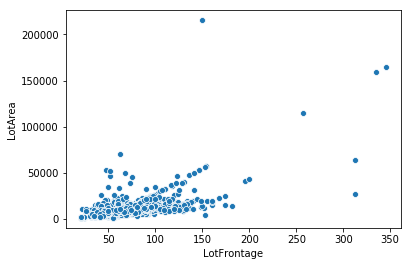

In [5]:
def fillnaFrontageBasedOnLinearRegressionWithArea(X):
    X = X.copy()
    oldIndex = X.index.copy()
    X = X.reset_index()
    naRows = X.loc[pd.isnull(X.LotFrontage)][['LotFrontage', 'LotArea']]
    naRowsIdxes = naRows.index.copy()
    anRows = X.loc[pd.notnull(X.LotFrontage)][['LotFrontage', 'LotArea']]
    linear = LinearRegression(n_jobs=-1)

    xTr, yTr = anRows[['LotArea']], anRows.LotFrontage
    xTest = naRows[['LotArea']]

    linear.fit(xTr, yTr)
    yTest = linear.predict(xTest)

    update = pd.DataFrame(index=naRowsIdxes, data={'LotFrontage':yTest})
    X.update(update)

    X.index = oldIndex

    sns.scatterplot(X.LotFrontage, X.LotArea)
    
    return X

#a = fillnaFrontageBasedOnLinearRegressionWithArea(merged)

merged = fillnaFrontageBasedOnLinearRegressionWithArea(merged)

In [6]:
def customFillna(X:pd.DataFrame):
    X = X.copy()
    # pool
    X['HasPool'] = X.PoolArea.apply(lambda x: int(x > 0))
    X.PoolQC.fillna(value='NA', inplace=True)
    #X.drop(columns=['PoolQC', 'PoolArea'], inplace=True)
    
    X.MiscFeature.fillna(value='NA', inplace=True)
    
    X.Alley.fillna(value='NA', inplace=True)
    
    X.Fence.fillna(value='NA', inplace=True)
    
    X.FireplaceQu.fillna(value='NA', inplace=True)
    
    # lot frontage
    X.LotFrontage.fillna(value=X.LotFrontage.mean(), inplace=True)
    #X.drop(columns=['LotFrontage'], inplace=True)
    
    # Garage
    garageObjFeatures = [x for x in list(X.select_dtypes(include=['object']).columns) if 'Garage' in x]
    for feat in garageObjFeatures:
        X[feat].fillna(value='NA', inplace=True)
        
    # Garage year built
    X.GarageYrBlt.fillna(value=0, inplace=True)
    
    # Bsmt
    bsmtFeatures = [x for x in list(X.select_dtypes(include=['object']).columns) if 'Bsmt' in x]
    for feat in bsmtFeatures:
        X[feat].fillna(value='NA', inplace=True)
    
    # Mas
    X.MasVnrArea.fillna(value=0, inplace=True)
    X.MasVnrType.fillna(value='NA', inplace=True)
    
    # Object NA less than 10:
    isnaObjFeats = pd.isnull(X.select_dtypes(include=['object'])).sum()
    isnaObjFeats = list(isnaObjFeats[(isnaObjFeats > 0) & (isnaObjFeats < 10)].index)
    for feat in isnaObjFeats:
        X[feat].fillna(value=X[feat].mode()[0], inplace=True)
        
    # Numerical NA less than 10:
    isnaNumFeats = pd.isnull(X.select_dtypes(exclude=['object'])).sum()
    isnaNumFeats = list(isnaNumFeats[(isnaNumFeats > 0) & (isnaNumFeats < 10)].index)
    for feat in isnaNumFeats:
        X[feat].fillna(value=0, inplace=True)
    
    return X
    


In [7]:
a = customFillna(merged)
na = pd.isna(a).sum()
assert na[na > 0].sort_values().count() == 1

In [8]:
merged = customFillna(merged)

# Transform data

In [9]:
logTransformTarget = False
boxcoxData = True

def transformData(X:pd.DataFrame):
    X = X.copy()
    
    if boxcoxData:
        lam=0.1

        for col in ('BsmtFinSF2', 'BsmtHalfBath', 'MasVnrArea',
               'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
               'GarageYrBlt', 'LotFrontage'):
            X[col]=boxcox1p(X[col],lam)
        
    if logTransformTarget:
        X.SalePrice = X.SalePrice.apply(lambda x: np.log(x) if pd.notnull(x) else x)
        
    return X

In [10]:
merged = transformData(merged)

# Encoding

In [11]:
catMSSubClass = True
encodingByMedian = True

def valueEncodingByMedian(X:pd.DataFrame):
    X = X.copy()
    
    catFeatures = list(X.select_dtypes(include=['object']).columns)
    numFeatures = list(X.select_dtypes(exclude=['object']).columns)
    if encodingByMedian:
        #dummies = pd.get_dummies(merged, columns=catFeatures)

        def getRankByMeanPrice(catFeat:str, X:pd.DataFrame):
            '''
            Map a feature unique values to according list of integers where higher interger means higher mean/median SalePrice
            '''
            medianByFeat = merged.groupby(by=[catFeat]).SalePrice.median().sort_values()
            return {val:rank for rank, val in enumerate(medianByFeat.index)}

        for feat in catFeatures:
            uniqueValsAndRanks = getRankByMeanPrice(feat, X)
            X[feat] = X[feat].map(uniqueValsAndRanks)
    else:
        X = pd.get_dummies(X, columns=catFeatures)
        
    if catMSSubClass:
        X['MSSubClass']=X['MSSubClass'].astype(str)
        X = pd.get_dummies(X, columns=['MSSubClass'])
        
    return X

In [12]:
merged = valueEncodingByMedian(merged)
print(merged.columns)

Index(['index', 'Id', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'W

# Drop

In [13]:
merged.drop(columns=['Id'], inplace=True)
merged.drop(columns=['GarageArea','1stFlrSF','TotRmsAbvGrd','2ndFlrSF'], inplace=True)

# Train and test

In [14]:
train = merged.iloc[:train.shape[0], :]
train;

In [15]:
test = merged.iloc[train.shape[0]:, :]
test;

### Removing outliers recomended by author

In [16]:
train = train[train['GrLivArea']<4000]

In [17]:
xTrain = train.drop(columns=['SalePrice'])
yTrain = train.loc[:, 'SalePrice']

In [18]:
xTest = test.drop(columns=['SalePrice'])

# Scale

In [19]:
scaleFeats = True
if scaleFeats:
    scaler = StandardScaler()
    xTrain = scaler.fit_transform(xTrain)
    xTest = scaler.transform(xTest)

C:\Anaconda3x64\envs\ml\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3x64\envs\ml\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Anaconda3x64\envs\ml\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


# Dimensionality reduction

In [20]:
performPCA = False

if performPCA:
    pca = PCA(n_components=10, random_state=42)
    pca.fit(xTrain)
    
    print(pca.explained_variance_ratio_)
    
    xTrain = pca.transform(xTrain)
    xTest = pca.transform(xTest)

# Model

In [21]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

## XGB

xgb = XGBRegressor(random_state=42, n_jobs=-1)

fullPipeline = Pipeline(steps=[
    #('featureEngPipeline', featureEngPipeline),
    #('transformPipeline', transformPipeline),
    ('model', xgb)
])

one_to_left = stats.beta(10, 1)  
from_zero_positive = stats.expon(0, 50)
param_dis = {  
    "model__n_estimators": stats.randint(40, 200),
    "model__max_depth": stats.randint(10, 50),
    "model__learning_rate": stats.uniform(0.05, 0.4),
    #"colsample_bytree": one_to_left,
    #"model__subsample": one_to_left,
    #"model__gamma": stats.uniform(0, 10),
    #'model__reg_alpha': from_zero_positive,
    "model__min_child_weight": stats.randint(1, 7),
}

RSXGB = RandomizedSearchCV(fullPipeline, param_dis, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1, cv=5, iid=False)
scores = cross_val_score(RSXGB, xTrain, yTrain, scoring='neg_mean_squared_error', cv=5);

scores.mean()

## LGBM

In [22]:
lg = lgb.LGBMRegressor(random_state=42, n_jobs=-1)

fullPipeline = Pipeline(steps=[
    #('featureEngPipeline', featureEngPipeline),
    #('transformPipeline', transformPipeline),
    #('scaler', StandardScaler()),
    ('model', lg)
])

param_dis = {
    'model__max_depth': stats.randint(25, 76),
    'model__learning_rate': stats.uniform(0.01, 0.1),
    'model__num_leaves': stats.randint(300, 1201),
    'model__n_estimator': [200]
}

RSLGB = RandomizedSearchCV(fullPipeline, param_dis, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1, cv=5, iid=False)
RSLGB_scores = cross_val_score(RSLGB, xTrain, yTrain, scoring='neg_mean_squared_error', cv=5);
RSLGB_scores.mean()

In [23]:
param_grid = {
    'model__max_depth': [25,50, 75],
    'model__learning_rate': [0.01,0.05,0.1],
    'model__num_leaves': [300,900,1200],
    'model__n_estimators': [200]
}

GSLGB = GridSearchCV(fullPipeline, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, iid=False)
GSLGB_scores = cross_val_score(GSLGB, xTrain, yTrain, scoring='neg_mean_squared_error', cv=5);
GSLGB_scores.mean()

KeyboardInterrupt: 

In [ ]:
-540520568.322767
549509045.6622269

## Lasso

lasso = Lasso(random_state=42, alpha=0.001)

fullPipeline = Pipeline(steps=[
    #('featureEngPipeline', featureEngPipeline),
    #('transformPipeline', transformPipeline),
    ('model', lasso)
])

lasso_scores = cross_val_score(lasso, xTrain, yTrain, scoring='neg_mean_squared_error', cv=5);
lasso_scores.mean()

# Submission

In [ ]:
model = GSLGB.fit(xTrain, yTrain)

In [ ]:
pred = model.predict(xTest)

if logTransformTarget:
    pred = np.exp(pred)

In [ ]:
output=pd.DataFrame({'Id':testIds,'SalePrice':pred})

In [ ]:
output.to_csv('submission.csv', index=False)

In [ ]:
output.head()